In [1139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft, ifft
from scipy.fft import fftfreq
from cmath import *
from tqdm import tqdm
from defaultlist import defaultlist
from scipy.optimize import minimize

In [1140]:
config = {}
config['STARTED_SIGNAL'] = defaultlist(complex)
config['TRANSLATED_SIGNAL'] = defaultlist(complex)

In [1142]:
#HYPERPARAMETERS
config = {}
config['ENCODING'] = 'utf-8'
config['BINARY_TO_COMPLEX'] = QAM16toComplex
config['COMPLEX_TO_BINARY'] = QAM16toBinary
config['T'] = 0.5
config['BETA'] = 0.66
config['NUMBER_OF_POINTS'] = 51
config['BETA2'] = 0.1
config['GAMMA'] = -0.0005
config['A'] = 0
config['B'] = 500
config['LENGTH'] = config['B'] - config['A']
config['NUMBER_OF_STEPS'] = 5000
config['METHOD'] = SecondOrderMethod
config['OPTIMIZE'] = 'Powell'
config['BEGIN'] = 0

In [1143]:
basic_text = 'Спасибо за курс! Зачтите лабу, пожалуйста)'

In [1144]:
t = from_text_to_binary(basic_text)
t = from_binary_to_text(t)

# Преобразование - текст <> бинарная последовательность

In [1145]:
def from_text_to_binary(text):
    return ''.join(format(i, '08b') for i in bytearray(text, encoding = config['ENCODING']))

In [1146]:
def from_binary_to_text(b_sequence):
    b_sequence = int(b_sequence, 2)
    byte_number = b_sequence.bit_length() + 7 // 8
    binary_array = b_sequence.to_bytes(byte_number, "big")
    ascii_text = binary_array.decode()
    return ascii_text

# Преобразование - бинарная последовательность <> комплексные числа

In [1147]:
def QPSKtoComplex(b_sequence):
    result_complex = []
    for i in range(int(len(b_sequence) / 2)):
        el = b_sequence[2 * i] + b_sequence[2 * i + 1]
        if el == '00':
            result_complex.append(-1-1j)
        elif el == '01':
            result_complex.append(-1+1j)
        elif el == '10':
            result_complex.append(1-1j)
        elif el == '11':
            result_complex.append(1+1j)
        else:
            result_complex.append(-1-1j)
    return result_complex

In [1148]:
def GetDistance(element, phases):
    answer = 0
    dist = inf
    for phase in phases:
        if(abs(element - phase) < dist):
            answer = phase
            dist = abs(element - phase)
    return answer

In [1149]:
def QPSKtoBinary(complex_list):
    phases = [-1-1j, -1+1j, 1-1j, 1+1j]
    result_b = ''
    #ищем ближайшую дистанцию к искомому классу:
    for el in complex_list:
        ans = GetDistance(el, phases)
        if ans == -1-1j:
            result_b += '00'
        elif ans == -1+1j:
            result_b += '01'
        elif ans == 1-1j:
            result_b += '10'
        elif ans == 1+1j:
            result_b += '11'
        else: 
            result_b += '00'
    return result_b

In [1150]:
def QAM16toBinary(complex_list):
    result_b = ''
    phases = [-3-3j, -3-1j, -3+3j, -3+1j, -1-3j, -1-1j, -1+3j, -1+1j, 3-3j,3-1j, 3+3j, 3+1j, 1-3j, 1+3j, 1-1j, 1+1j]
    for el in complex_list:
        el = GetDistance(el, phases)
        if el == -3-3j:
            result_b += '0000'
        elif el == -3-1j:
            result_b += '0001'
        elif el == -3+3j:
            result_b += '0010'
        elif el == -3+1j:
            result_b += '0011'
        elif el == -1-3j:
            result_b += '0100'
        elif el == -1-1j:
            result_b += '0101'
        elif el == -1+3j:
            result_b += '0110'
        elif el == -1+1j:
            result_b += '0111'
        elif el == 3-3j:
            result_b += '1000'
        elif el == 3-1j:
            result_b += '1001'
        elif el == 3+3j:
            result_b += '1010'
        elif el == 3+1j:
            result_b += '1011'
        elif el == 1-3j:
            result_b += '1100'
        elif el == 1-1j:
            result_b += '1101'
        elif el == 1+3j:
            result_b += '1110'
        elif el == 1+1j:
            result_b += '1111'
        else:
            result_b += '0000'
    return result_b

In [1151]:
def QAM16toComplex(b_sequence):
    result_complex = []
    for i in range(int(len(b_sequence) / 4)):
        el = b_sequence[4 * i] + b_sequence[4 * i + 1] + b_sequence[4 * i + 2] + b_sequence[4 * i + 3]
        if el == '0000':
            result_complex.append(-3-3j)
        if el == '0001':
            result_complex.append(-3-1j)
        if el == '0010':
            result_complex.append(-3+3j)
        if el == '0011':
            result_complex.append(-3+1j)
        if el == '0100':
            result_complex.append(-1-3j)
        if el == '0101':
            result_complex.append(-1-1j)
        if el == '0110':
            result_complex.append(-1+3j)
        if el == '0111':
            result_complex.append(-1+1j)
        if el == '1000':
            result_complex.append(3-3j)
        if el == '1001':
            result_complex.append(3-1j)
        if el == '1010':
            result_complex.append(3+3j)
        if el == '1011':
            result_complex.append(3+1j)
        if el == '1100':
            result_complex.append(1-3j)
        if el == '1101':
            result_complex.append(1-1j)
        if el == '1110':
            result_complex.append(1+3j)
        if el == '1111':
            result_complex.append(1+1j)
    return result_complex

# преобразование - комплексные числа <> нелинейный сигнал

In [1152]:
def raised_cosine(t):
    return np.sinc(t / config['T']) * np.cos(np.pi * config['BETA'] * t / config['T']) / (1 - 4 * config['BETA'] ** 2 * t ** 2 / (config['T'] ** 2))

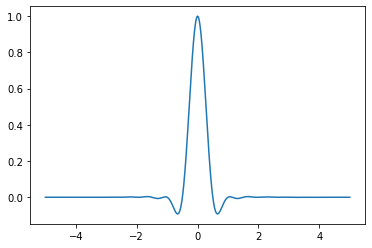

In [1153]:
temp = np.linspace(-5, 5, 1000)
u = [raised_cosine(el) for el in temp]
plt.plot(temp, u)

In [1154]:
def ComplexToSignal(complex_list):
    signal_mesh = np.linspace(0, len(complex_list)*config['T'], len(complex_list)*config['NUMBER_OF_POINTS'])
    signal = np.zeros((len(signal_mesh),), dtype = complex)
    for i in range(len(complex_list)):
        curr_f = np.array([raised_cosine(el - i * config['T'] - config['T'] / 2) for el in signal_mesh])
        curr_layer = complex_list[i] * curr_f
        signal += curr_layer
    return signal_mesh, signal

# Прогонка по волокну

In [1155]:
def NonLinear(grid, step):
    new_grid = []
    for obj in grid:
        new_grid.append(obj*exp(1j*config['GAMMA']*step*(abs(obj)**2)))
    return new_grid

def Dispersion(grid, w, step):
    new_grid = []
    for obj, psi in zip(grid, w):
        new_grid.append(obj * exp((1j*config['BETA2']*step*psi**2)/2))
    return new_grid

def HalfDispersion(grid, w, step):
    new_grid = []
    for obj, psi in zip(grid, w):
        new_grid.append(obj * exp((1j*config['BETA2']*step*psi**2)/4))
    return new_grid

def BackDispersion(grid, w):
    new_grid = []
    for obj, psi in zip(grid, w):
        new_grid.append(obj*exp((-1j*config['BETA2']*psi**2*config['LENGTH'])/2))
    return new_grid

# Распространение сигнала

In [1156]:
def FirstOrderMethod(grid, w, step):
    grid = NonLinear(grid, step)
    grid = fft(grid)
    grid = Dispersion(grid, w, step)
    grid = ifft(grid)
    return grid

In [1157]:
def SecondOrderMethod(grid, w, step):
    grid = fft(grid)
    grid = HalfDispersion(grid, w, step)
    grid = ifft(grid)
    grid = NonLinear(grid, step)
    grid = fft(grid)
    grid = HalfDispersion(grid, w, step)
    grid = ifft(grid)
    return grid

In [1158]:
def DispersionBackPropagation(grid, w, step):
    grid = fft(grid)
    grid = BackDispersion(grid, w)
    grid = ifft(grid)
    return grid

In [1159]:
def FinalPropagation(signal, freqs):
    step = (config['B'] - config['A'])/config['NUMBER_OF_STEPS']
    old_signal = signal
    for i in tqdm(range(config['NUMBER_OF_STEPS'])):
        new_signal = config['METHOD'](old_signal, freqs, step)
        old_signal = new_signal
    new_signal = DispersionBackPropagation(new_signal, freqs, step)
    return new_signal

# Фильтрация сигнала

In [1160]:
def Filtration(grid):
    filtrated = []
    v = int((config['NUMBER_OF_POINTS'] - 1)/2)
    for val in range(v, len(grid) - v, config['NUMBER_OF_POINTS']):
        filtrated.append(grid[val])
        
    return filtrated

# Подбор фазы

In [1161]:
def f(x):
    summ = 0
    for true_val, wrong_val in zip(config['STARTED_SIGNAL'], config['TRANSLATED_SIGNAL']):
        summ += abs(true_val - wrong_val*exp(1j*x))
    return summ

In [1162]:
def GetPhase():
    res = minimize(f, config['BEGIN'], method = config['OPTIMIZE'], bounds = [(-80,80)])
    return res.x

# Итоговое решение

In [1163]:
#текст в бинарник
text = from_text_to_binary(basic_text)

In [1164]:
true_binary = text

In [1165]:
len(text)

608

In [1166]:
#бинарник в комплексные числа
text = config['BINARY_TO_COMPLEX'](text)

In [1167]:
#комплексные числа в сигнал
mesh, signal = ComplexToSignal(text)

/Users/andrlluuk/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


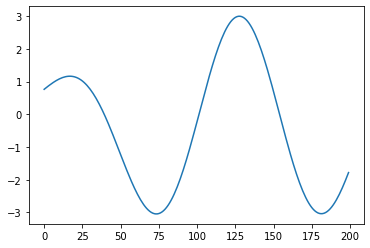

In [1192]:
plt.plot(signal[:200])

In [1168]:
config['STARTED_SIGNAL'] = text

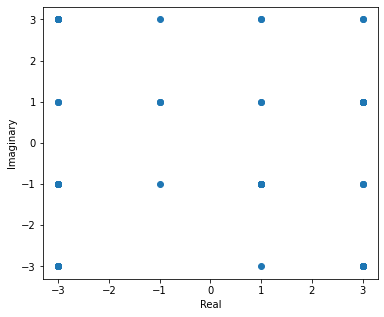

In [1169]:
x = [ele.real for ele in text]
y = [ele.imag for ele in text]
  
fig = plt.figure(figsize=(6,5))

plt.scatter(x, y)
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.show()

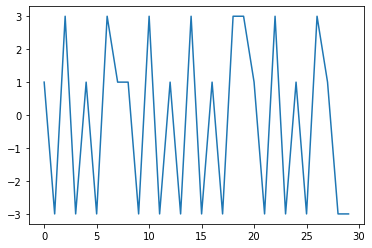

In [1189]:
plt.plot(config['STARTED_SIGNAL'][:30])

In [1171]:
old_filtrated_signal = Filtration(signal)

In [1172]:
#настройка частот
freqs = fftfreq(len(mesh), (mesh[-1] - mesh[0])/len(mesh))*2*pi

In [1173]:
#распространение сигнала
new_signal = FinalPropagation(signal, freqs)

  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-1094-e47e3a3d8242>:2: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  grid = fft(grid)
<ipython-input-1094-e47e3a3d8242>:4: DeprecationWarning: scipy.ifft is deprecated and will be removed in SciPy 2.0.0, use scipy.fft.ifft instead
  grid = ifft(grid)
<ipython-input-1094-e47e3a3d8242>:6: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  grid = fft(grid)
<ipython-input-1094-e47e3a3d8242>:8: DeprecationWarning: scipy.ifft is deprecated and will be removed in SciPy 2.0.0, use scipy.fft.ifft instead
  grid = ifft(grid)
100%|██████████| 5000/5000 [02:09<00:00, 38.62it/s]


In [1174]:
filtrated_signal = Filtration(new_signal)

In [ ]:
plt.plot(config[''])

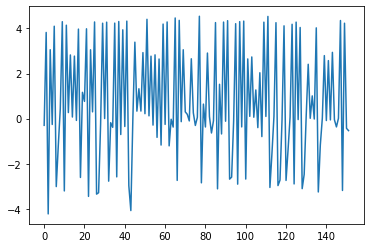

In [1175]:
plt.plot(filtrated_signal)

In [1176]:
config['TRANSLATED_SIGNAL'] = filtrated_signal

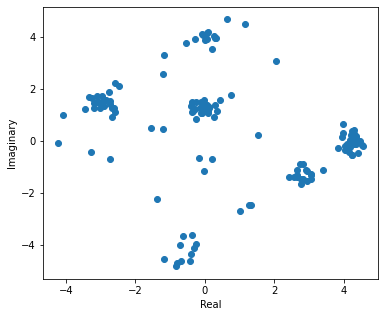

In [1177]:
x = [ele.real for ele in filtrated_signal]
y = [ele.imag for ele in filtrated_signal]
  
fig = plt.figure(figsize=(6,5))

plt.scatter(x, y)
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.show()

In [1178]:
phase = GetPhase()

In [1179]:
phase

array([-46.32225786])

In [1180]:
fs = np.array(filtrated_signal, dtype = complex)*exp(1j*phase)

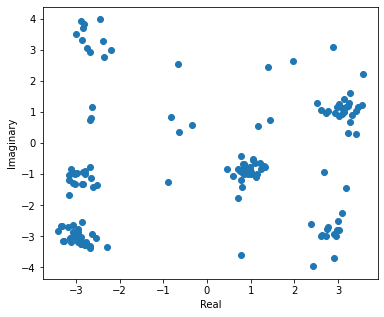

In [1181]:
x = [ele.real for ele in fs]
y = [ele.imag for ele in fs]
  
fig = plt.figure(figsize=(6,5))

plt.scatter(x, y)
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.show()

In [1182]:
binary = config['COMPLEX_TO_BINARY'](fs)

In [1183]:
binary

'11010000101000011101000010111111110100001011000011010001100000011101000010111000110100001011000111010000101111100010000011010000101101111101000010110000001000001101000010111010110100011000001111010001100000001101000110000001001000010010000011010000100101111101000010110000110100011000011111010001100000101101000010111000110100011000001011010000101101010010000011010000101110111101000010110000110100001011000111010001100000110010110000100000110100001011111111010000101111101101000010110110110100001011000011010000101110111101000110000011110100001011100111010001100000011101000110000010110100001011000000101000'

In [1184]:
print(sum([1 for i in zip(true_binary, binary) if i[0] != i[1]]))

1


In [1185]:
len(binary)

608

In [1186]:
final_text = from_binary_to_text(binary)

In [1187]:
ft = ''
for el in final_text:
    if el != '/x0':
        ft += el

In [1188]:
print(ft)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Спасибо за курс! Зачтите лабу, пожалуйста(
